# 최적화 기법이란 ?
---
아래의 수식은 최적화 기법을 풀기 위한 목적함수 (Objective function) 의 기본적인 형태입니다.

>$x^* = \arg \min_{x} F(x) + \lambda R(x)$,

이때, $F(\cdot)$ fidelity term 이며, $R(\cdot)$ 은 regularization term (or penalty term), and $\lambda$ 는 fidelity term $F(x)$ 와 regularization term $R(x)$ 의 균형을 맟추기 위한 hyper-parameter 입니다.

일반적으로, fidelity term $F(x)$ 은 아래와 같이 수식화 할 수 있습니다:

>$F(x) = \frac{1}{2} || Ax - y ||_2^2$,

이때, $A$ 는 system matrix, $x$ 는 복원하고자 하는 영상, 그리고 $y$ 는 system matrix $A$ 로 부터 획득된 measurement 입니다.
참고로, 이전 챕터 1에서 우리는 가우시안 블러 커널을 system matrix $A$ 로 사용하였습니다.


그리고 regularization term $R(x)$ 는 복원 영상 $x$ 의 사전 정보 (prior knowledge) 를 강조할 수 있는 함수이며,
주로 total variation (TV) 과 low-rankness 등이 활용됩니다.


1. Total variation (TV) penalty\
__: 영상 $x$ 가 piece-wise smooth 하여 인접한 픽셀간의 차분값이 매우 작다는 사전 정보 (prior knowledge) 에 의거해 정의된 penalty term.__

>$R(x) = \sum_{i=1}^{N}\sum_{j=1}^{N}|D_{\textrm{x}}(x_{(i,j)})| + |D_{\textrm{y}}(x_{(i,j)})|$,

  이때, $D_{\textrm{x}}(x_{(i,j)})=x_{(i,j)} - x_{(i,j-1)}$ 와 $D_{\textrm{y}}(x_{(i,j)})=x_{(i,j)} - x_{(i-1,j)}$ 는 $\textrm{x}$-axis 와 $\textrm{y}$-axis 에 대한 미분 함수 입니다.

2. Low-rankness penalty\
__: 전체 영상 $x$ 또는 일부 영상 $P_i x$ (이때, $P_i$ 는 패치를 추출하는 연산자) 의 링크 $r = \textrm{RANK}(x)$ 가 low-rank 인 $r << N$ (이때, $N$ 은 full-rank) 를 만족한다는 사전 정보 (prior knowledge) 에 의거해 정의된 penalty term.__

>$R(x) = \textrm{RANK}(x) < k$,

  이때, $k$ 는 $x$ 의 rank-constraint 입니다.

아래의 수식은 우리가 앞으로 다루어야 할 목적 함수의 기본적인 형태입니다:

>$x^* = \arg \min_{x} \frac{1}{2} || A x - y ||_2^2 + \lambda R(x)$

이때, $A$ 는 system matrix, $x$ 는 복원하고자 하는 영상, 그리고 $y$ 는 system matrix $A$ 로 부터 획득된 measurement 입니다. 그리고, $R(\cdot)$ 은 regularization term (or penalty term), and $\lambda$ 는 fidelity term $|| A x - y ||_2^2$ 와 regularization term $R(x)$ 의 균형을 맟추기 위한 hyper-parameter 입니다.

# 구현
---
여기서, 우리는 잘 알려진 regularization terms 인 total variation (TV) penalty 과 low-rankness penalty 를 구현해 보도록 하겠습니다.

## 패키지 추가하기

In [ ]:
import numpy as np
from numpy.linalg import svd

from skimage.data import shepp_logan_phantom
from skimage.transform import resize

import matplotlib.pyplot as plt

## Total variation (TV) penalty 정의하기

### TV operations

In [ ]:
def Dx(src):
  dst = np.zeros_like(src)

  dst[:, 1:] = src[:, 1:] - src[:, 0:-1]
  dst[:, 0] = src[:, 0] - src[:, -1]

  return dst

def Dy(src):
  dst = np.zeros_like(src)

  dst[1:, :] = src[1:, :] - src[0:-1, :]
  dst[0, :] = src[0, :] - src[-1, :]

  return dst


## Low-rankness penalty 정의하기

### Low-rankness operations

In [ ]:
def LowRankness(src, th=0):
  u, s, vh = svd(src)

  s[s < th] = 0

  dst = np.dot(u, np.dot(np.diag(s), vh))

  return dst, u, s, vh

## Penalty terms $R(x)$ 을 영상 $x$ 에 적용하기

In [ ]:
# Load the image
N = 512
src = shepp_logan_phantom()
src = resize(src, output_shape=(N, N))

# Apply the Total variation along the x- and y-axis to the image
src_dx = Dx(src)
src_dy = Dy(src)

# Apply the Low-rankness to the image
th = 5e0
_, _, s_org, _ = LowRankness(src)
# _, _, s_low, _ = LowRankness(src, th=th)


## 결과 출력하기

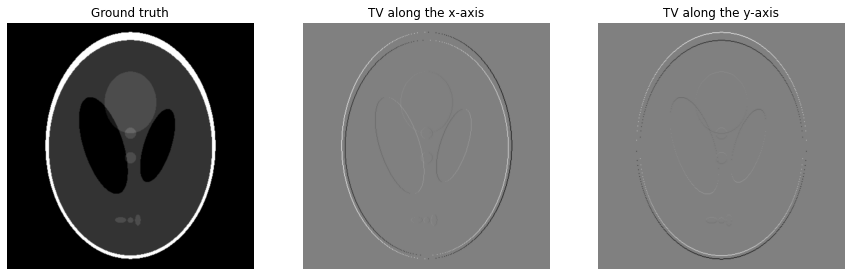

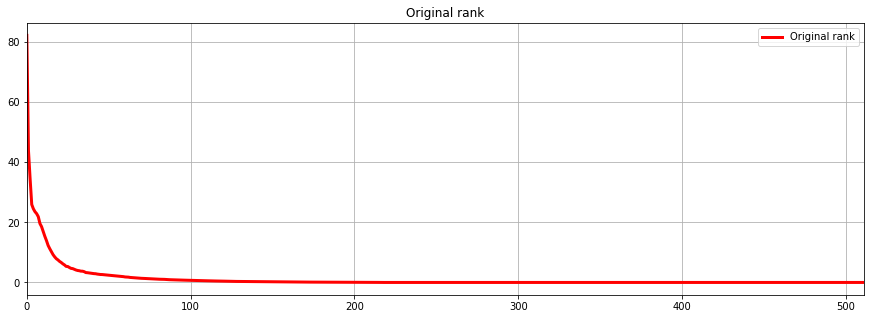

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))

ax = axs[0]
ax.axis(False)
ax.set_title('Ground truth')
ax.imshow(src, cmap='gray');

ax = axs[1]
ax.axis(False)
ax.set_title('TV along the x-axis')
ax.imshow(src_dx, cmap='gray');

ax = axs[2]
ax.axis(False)
ax.set_title('TV along the y-axis')
ax.imshow(src_dy, cmap='gray');

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15, 5))

ax.grid(True)
ax.set_title('Original rank')
ax.set_xlim([0, N-1])
ax.plot(s_org, '-r', linewidth=3, label='Original rank')
# ax.plot(s_low, '--g', linewidth=3, label='Low rank')
# ax.plot(th * np.ones(N), '--k', linewidth=2, label='Threshold level = %.2e' % th)
ax.legend()

plt.show()


# 결론
---
이번 챕터에서, 우리는 잘 알려진 regularization terms 인 total variation (TV) 과 low-rankness 에 대해 살펴보았습니다. 일반적으로, regularization terms 은 영상의 prior knowledge 를 강조할 수 있는 함수를 주로 사용합니다. 따라서, 최적화 기법을 적용하는 어플리케이션에 적합한 regularization terms 은 복원 영상의 질을 향상시킬 수 있습니다.

# 참고자료: 다양한 최적화 기법들
---

위의 목적함수에 기반하여, 최적화된 복원영상 $x^*$ 를 찾기 위한 다양한 최적화 기법들은 아래와 같습니다.

1. [Gradient descent method](https://en.wikipedia.org/wiki/Gradient_descent)
2. [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method)
3. [Conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method)
4. [Iterative Shrinkage-Thresholding Algorithm](http://www.cs.cmu.edu/afs/cs/Web/People/airg/readings/2012_02_21_a_fast_iterative_shrinkage-thresholding.pdf)
5. [Fast Iterative Shrinkage-Thresholding Algorithm](http://www.cs.cmu.edu/afs/cs/Web/People/airg/readings/2012_02_21_a_fast_iterative_shrinkage-thresholding.pdf)
6. [Alternating Direction Method of Multipliers](https://web.stanford.edu/~boyd/papers/pdf/admm_distr_stats.pdf)


# 다음
---

[다음 챕터](https://colab.research.google.com/drive/1tlOUw92mmyWnUW2f72DfeR0EK8RhkKtT?usp=sharing) 에선, 우리는 가장 기본적인 최적화 기법인 gradient descent method 에 대해 알아보도록 하겠습니다.